# Microsoft Studios - Industry Analysis
### By Yongwei & Yazan

### The Project
Microsoft sees all the big companies creating original video content, and they want to get in on the fun. They have decided to create a new movie studio, but the problem is they don’t know anything about creating movies. They have hired you to help them better understand the movie industry. Your team is charged with doing data analysis and creating a presentation that explores what type of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the CEO can use when deciding what type of films they should be creating.

### Questions of Interest
The following questions will be analyzed using 2 different measures of success: Review Rating & Commercial Performance. 

Review Rating
    1. What are the best rated films since 2000?
    2. Of these films, which genres are most prevalent? 
    3. Analyzing the top 3 genres, what is the relationship between a films review score and its popularity?
    4. What is the relationship betwen a film's review score and the number of reviews?
    5. Which directors should we consider hiring? (That is, those who have worked on the highest number of highly rated films)
    6. Which writers should we consider hiring? (That is, those who have worked on the highest number of highly rated films)

Financial Success
    1. A
    2. B
    3. C
    
Finally, when we combine the highest rated films with the most commercially successful:
    1. What are the best performing films across both standards?
    2. What are the most common genres, directors, and writers?
    3. What is the relationship between commercial success and review rating?

### Import packages & connect database

In [1]:
#!pip install mysql-connector-python
#!pip install fuzzywuzzy
#!pip install python-Levenshtein

In [2]:
import pandas as pd
import numpy as np
import mysql.connector
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import string
#from fuzzywuzzy import fuzz
#from fuzzywuzzy import process
%matplotlib inline

In [3]:
con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')
cur = con.cursor()

# Data Cleaning

### IMDB Titles

In [4]:
query = ('''
SELECT *
FROM imdb_title_basics imdb_b
JOIN imdb_title_crew imdb_c USING (tconst)
JOIN imdb_title_ratings imdb_e USING (tconst)
''')
imdb_titles = pd.read_sql_query(query, con)
#joining all IMDB title tables using title ids and name ids

In [5]:
imdb_titles.isna().sum()
#checking for null values

tconst                 0
primary_title          0
original_title         0
start_year             0
runtime_minutes     7620
genres                 0
directors              0
writers            10561
averagerating          0
numvotes               0
dtype: int64

In [6]:
imdb_titles = imdb_titles.dropna(subset=['runtime_minutes'])
imdb_titles = imdb_titles.dropna(subset=['writers'])
#Removing rows with null values for runtime minutes and writers

In [7]:
pd.set_option('display.max_columns',None)
# Want to see all columns to see which are going to be useful

In [8]:
imdb_titles['genres'] = imdb_titles['genres'].map(lambda x: x.split(','))
imdb_titles['directors'] = imdb_titles['directors'].map(lambda x: x.split(','))
imdb_titles['writers'] = imdb_titles['writers'].map(lambda x: x.split(','))
# Converting genres, directors, writers to lists, so we can easily check most popular later.

In [9]:
imdb_titles['age_of_movie']= 2020 - imdb_titles['start_year']
#Creating new column to have "age of movie" as a reference

In [10]:
translator1 = str.maketrans('0123456789','..........')
translator2 = str.maketrans('', '', string.punctuation)
imdb_titles['dummy_title'] = imdb_titles.primary_title.map(lambda x: x.translate(translator1).translate(translator2).strip())
#Dropping numbers and punctuation marks from primary_title to make a dummy key

imdb_titles['dummy_title'] = imdb_titles['dummy_title'].str.replace('[ ]','_')
imdb_titles['dummy_title'] = imdb_titles['dummy_title'].str.lower()
imdb_titles['dummy_title'] = imdb_titles['dummy_title'].map(lambda x: x.strip())
#Creating a dummy_title column, to be used for our dummy key

In [11]:
imdb_titles['start_year'] = imdb_titles['start_year'].map(lambda x: str(x))
#Turning start_year to string so that I can combine it with dummy_title in another column

In [12]:
imdb_titles['dummy_key'] = imdb_titles['dummy_title'] + "_" + imdb_titles['start_year']
#Creating a new column for dummy_key

In [13]:
imdb_titles = imdb_titles.drop(columns=['dummy_title'])
#removing dummy_title since I have the dummy_key I need

### IMDB Crew

In [14]:
query = ('''
SELECT *
FROM imdb_name_basics
''')
imdb_crew = pd.read_sql_query(query, con)

In [15]:
imdb_crew.isna().sum()
# Checking for null values

nconst                     0
primary_name               0
birth_year            523912
death_year            599865
primary_profession         0
known_for_titles           0
dtype: int64

In [16]:
imdb_crew = imdb_crew.fillna(0)
#Replacing null values with 0

In [17]:
imdb_crew['birth_year'] = imdb_crew['birth_year'].map(lambda x: int(x))
imdb_crew['death_year'] = imdb_crew['death_year'].map(lambda x: int(x))
#Converting birth years and death years to integer

In [18]:
imdb_crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   nconst              606648 non-null  object
 1   primary_name        606648 non-null  object
 2   birth_year          606648 non-null  int64 
 3   death_year          606648 non-null  int64 
 4   primary_profession  606648 non-null  object
 5   known_for_titles    606648 non-null  object
dtypes: int64(2), object(4)
memory usage: 27.8+ MB


In [19]:
imdb_crew['primary_profession'] = imdb_crew['primary_profession'].map(lambda x: x.split(','))
imdb_crew['known_for_titles'] = imdb_crew['known_for_titles'].map(lambda x: x.split(','))
#Converting these to lists so we can easily reference them later

In [20]:
imdb_crew['age'] = imdb_crew.apply(lambda row: (2020 - row['birth_year']) if row['death_year'] == 0 else None, axis=1)
#Adding an age column. If the age is 2020, it means that there is no birth year available. If the age is equal to None, it means the person is dead.

### BOM

In [21]:
query = ('''
SELECT * FROM bom_movie_gross
''')
bom = pd.read_sql_query(query, con)

In [22]:
#drop Null value in domestic_gross
bom = bom.dropna(subset =['domestic_gross'])

#convert Null value in foreign_gross to 0
bom.foreign_gross = bom.foreign_gross.fillna(0)

#convert domestic_gross and foreign_gross from float to int
bom.domestic_gross = bom.domestic_gross.map(lambda x: int(x))   
bom.foreign_gross = bom.foreign_gross.map(lambda x: int(x))  

In [23]:
#remove spaces on both end of strings
bom.title = bom.title.map(lambda x: x.strip())
bom.studio = bom.studio.map(lambda x: x.strip())

In [24]:
#convert year to str
bom['year'] = bom['year'].map(str)

#remove all punctuation and numbers inside movie title
translator1 = str.maketrans('0123456789','..........')
translator2 = str.maketrans('', '', string.punctuation)
bom['title_cleaned'] = bom.title.map(lambda x: x.translate(translator1).translate(translator2).strip())

#combine title and year
bom['title_cleaned'] = bom['title_cleaned'] + '_' + bom['year']

#replace all empty spaces with _ and lower all string
bom['title_cleaned'] = bom['title_cleaned'].str.replace(' ','_').str.lower()

#convert year back to int
bom['year'] = bom['year'].map(int)

### TN

In [25]:
query_tn = ('''
SELECT * FROM tn_movie_budgets
''')
tn = pd.read_sql_query(query_tn, con)

In [26]:
# convert release_date to date format
tn.release_date = tn.release_date.map(lambda x: dt.datetime.strptime(x, '%b %d, %Y'))

# convert production_budget, domestic_gross, worldwide_gross to date format
tn.production_budget = tn.production_budget.map(lambda x: int(x.replace(',','').replace('$','')))
tn.domestic_gross = tn.domestic_gross.map(lambda x: int(x.replace(',','').replace('$','')))
tn.worldwide_gross = tn.worldwide_gross.map(lambda x: int(x.replace(',','').replace('$','')))

#add profit column
tn['profit'] = tn.worldwide_gross - tn.production_budget

In [27]:
#add new column for release year
tn['year'] = tn.release_date.map(lambda x: str(x.year))

#remove all punctuation and numbers inside movie title
translator1 = str.maketrans('0123456789','..........')
translator2 = str.maketrans('', '', string.punctuation)
tn['title_cleaned'] = tn.movie.map(lambda x: x.translate(translator1).translate(translator2).strip())

#combine title and year
tn['title_cleaned'] = tn['title_cleaned']+'_'+tn['year']

#replace all empty spaces with _ and lower all string
tn['title_cleaned'] = tn['title_cleaned'].str.replace(' ','_').str.lower()

#drop column year
tn = tn.drop(axis = 1, columns='year')

### TMDB

In [28]:
query_tmdb = ('''
SELECT * FROM tmdb_movies
''')
tmdb = pd.read_sql_query(query_tmdb, con)

In [29]:
query_tmdb_link = ('''
SELECT * FROM tmdb_imdb_link
''')
tmdb_link = pd.read_sql_query(query_tmdb_link, con)

In [30]:
#convert genre_ids to int
tmdb.genre_ids.map(lambda x: int(x))

#remove spaces on both end of strings
tmdb.original_language = tmdb.original_language.map(lambda x: x.strip())
tmdb.original_title = tmdb.original_title.map(lambda x: x.strip())
tmdb.title = tmdb.title.map(lambda x: x.strip())

In [31]:
#Join tmdb and tmdb_link tables
tmdb = tmdb.join(tmdb_link.set_index('tmdb_id'), on = 'id', how = 'left')

In [32]:
#clean the joined table
tmdb.imdb_id = tmdb.imdb_id.fillna(0).map(lambda x: int(x))

In [33]:
#add new column for release year
tmdb['year'] = tmdb.release_date.map(lambda x: str(x.year))

#remove all punctuation and numbers inside movie title
translator1 = str.maketrans('0123456789','..........')
translator2 = str.maketrans('', '', string.punctuation)
tmdb['title_cleaned'] = tmdb.title.map(lambda x: x.translate(translator1).translate(translator2).strip())

#combine title and year
tmdb['title_cleaned'] = tmdb['title_cleaned']+'_'+tmdb['year']

#replace all empty spaces with _ and lower all string
tmdb['title_cleaned'] = tmdb['title_cleaned'].str.replace(' ','_').str.lower()

#drop column year
tmdb = tmdb.drop(axis = 1, columns='year')

### RT

In [34]:
query_rt_info = ('''
SELECT * FROM rt_movie_info
''')
rt_info = pd.read_sql_query(query_rt_info, con)

In [35]:
query_rt_reviews = ('''
SELECT * FROM rt_reviews
''')
rt_reviews = pd.read_sql_query(query_rt_reviews, con)

In [36]:
query_rt_link = ('''
SELECT * FROM rt_imdb_link
''')
rt_link = pd.read_sql_query(query_rt_link, con)

### RT_Info Cleaning

In [37]:
#replace empty value in theater_date and dvd_date with Jan 1,1000
rt_info['theater_date'].loc[rt_info.theater_date == ''] = 'Jan 1, 1000'
rt_info['dvd_date'].loc[rt_info.dvd_date == ''] = 'Jan 1, 1000'

C:\Users\yazan\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [38]:
#convert theater_date and dvd_date to datetime format
rt_info.theater_date = rt_info.theater_date.map(lambda x: dt.datetime.strptime(x, '%b %d, %Y').date())
rt_info.dvd_date = rt_info.dvd_date.map(lambda x: dt.datetime.strptime(x, '%b %d, %Y').date())

In [39]:
#clean box_office date
rt_info['box_office'].loc[rt_info.box_office == ''] = '0'
rt_info['box_office'] = rt_info.box_office.map(lambda x: int(x.replace(',', '')))

In [40]:
#clean runtime (replace empty value with 0)
rt_info['runtime'].loc[rt_info.runtime == ''] = '0'
rt_info['runtime'] = rt_info.runtime.map(lambda x: int(x.replace('minutes', '')))

In [41]:
#remove spaces on both end of strings
rt_info.synopsis = rt_info.synopsis.map(lambda x: x.strip())
rt_info.rating = rt_info.rating.map(lambda x: x.strip())
rt_info.genre = rt_info.genre.map(lambda x: x.strip())
rt_info.director = rt_info.director.map(lambda x: x.strip())
rt_info.writer = rt_info.writer.map(lambda x: x.strip())

In [42]:
rt_info['genre'] = rt_info['genre'].map(lambda x: x.split('|'))
rt_info['writer'] = rt_info['writer'].map(lambda x: x.split('|'))
rt_info['director'] = rt_info['director'].map(lambda x: x.split('|'))
#Converting genre, writer, director to list so we can reference them easily

In [43]:
rt_info = rt_info.drop(columns=['box_office','currency'],axis=1)
#Dropping box_office because we have better data on another table, dropping currency because we removed box office data

### RT_Reviews Cleaning

In [44]:
#convert date to datetime format
rt_reviews.date = rt_reviews.date.map(lambda x: dt.datetime.strptime(x, '%B %d, %Y').date())

In [45]:
#convert top_critic to int
rt_reviews.top_critic = rt_reviews.top_critic.map(lambda x: int(x))

In [46]:
#remove spaces on both end of strings
rt_reviews.review = rt_reviews.review.map(lambda x: x.strip())
rt_reviews.rating = rt_reviews.rating.map(lambda x: x.strip())
rt_reviews.fresh = rt_reviews.fresh.map(lambda x: x.strip())
rt_reviews.critic = rt_reviews.critic.map(lambda x: x.strip())
rt_reviews.publisher = rt_reviews.publisher.map(lambda x: x.strip())

### RT_link cleaning

In [47]:
rt_link.year = rt_link.year.fillna(1000)

In [48]:
rt_link.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17468 entries, 0 to 17467
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   imdbid       17468 non-null  int64  
 1   rtid         17468 non-null  int64  
 2   title        17468 non-null  object 
 3   year         17468 non-null  float64
 4   mpaa_rating  17468 non-null  object 
 5   runtime      17468 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 818.9+ KB


In [49]:
#replace empty space to year 1000 in year
rt_link.year = rt_link.year.fillna(1000)

#convert date to datetime format
rt_link.year = rt_link.year.map(lambda x: (int(x)))

In [50]:
#replace empty space in runtime to 0
rt_link['runtime'].loc[rt_link.runtime == ''] = '0'

#convert runtime to int format
rt_link.runtime = rt_link.runtime.map(lambda x: (int(x)))

In [51]:
#convert year to str
rt_link['year'] = rt_link['year'].map(str)

#remove all punctuation and numbers inside movie title
translator1 = str.maketrans('0123456789','..........')
translator2 = str.maketrans('', '', string.punctuation)
rt_link['title_cleaned'] = rt_link.title.map(lambda x: x.translate(translator1).translate(translator2).strip())

#combine title and year
rt_link['title_cleaned'] = rt_link['title_cleaned'] + '_' + rt_link['year']

#replace all empty spaces with _ and lower all string
rt_link['title_cleaned'] = rt_link['title_cleaned'].str.replace(' ','_').str.lower()

#convert year back to int
rt_link['year'] = rt_link['year'].map(int)

# Top 200 Profitable Movies after 2000

### Both BOM and TN have similar information about budget, but TN database is more complete so we decided to use TN to calculate profit.

In [52]:
# get top 200 revenue domestic movies after 2000
top200_revenue_domestic = tn.loc[tn.release_date>dt.datetime(2000,1,1)].sort_values('domestic_gross',ascending=False).head(200)

# get top 200 revenue worldwide movies after 2000
top200_revenue_world = tn.loc[tn.release_date>dt.datetime(2000,1,1)].sort_values('worldwide_gross',ascending=False).head(200)

# get top 200 profit movies after 2000
top200_profit = tn.loc[tn.release_date>dt.datetime(2000,1,1)].sort_values('profit',ascending=False).head(200)

In [53]:
top200_profit.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,title_cleaned
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,2351345279,avatar_2009
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,1748134200,avengers_infinity_war_2018
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220,star_wars_ep_vii_the_force_awakens_2015
33,34,2015-06-12,Jurassic World,215000000,652270625,1648854864,1433854864,jurassic_world_2015
66,67,2015-04-03,Furious 7,190000000,353007020,1518722794,1328722794,furious_2015


In [54]:
imdb_titles.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,directors,writers,averagerating,numvotes,age_of_movie,dummy_key
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"[Action, Crime, Drama]",[nm0712540],"[nm0023551, nm1194313, nm0347899, nm1391276]",7.0,77,7,sunghursh_2013
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,[Drama],[nm0000080],"[nm0000080, nm0462648]",6.9,4517,2,the_other_side_of_the_wind_2018
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"[Comedy, Drama, Fantasy]","[nm0765384, nm0749914]","[nm1360635, nm0749914]",6.5,119,3,the_wandering_soap_opera_2017
6,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"[Adventure, Animation, Comedy]",[nm0365480],[nm0365480],8.1,263,3,joe_finds_grace_2017
7,tt0146592,Pál Adrienn,Pál Adrienn,2010,136.0,[Drama],[nm1030585],"[nm1030585, nm1921430]",6.8,451,10,pál_adrienn_2010


In [55]:
# there are only 140 movies from top200_profit that can be find inside imdb datebdase. 
# So we narrowed our data to these 140 movies

top123_profit_imdb = imdb_titles.loc[imdb_titles.dummy_key.isin(list(top200_profit.title_cleaned))]

In [56]:
# drop original title
top123_profit_imdb = top123_profit_imdb.drop(axis = 1, columns = 'original_title')

In [57]:
#join tn and imdb database together for top 140 movies
top123_profit_1 = top123_profit_imdb.merge(
    top200_profit, left_on='primary_title', right_on ='movie').drop(
    axis=1, columns=['start_year', 'id'])

In [58]:
top123_profit_2 = top123_profit_imdb.merge(
    top200_profit, left_on='dummy_key', right_on ='title_cleaned').drop(
    axis=1, columns=['start_year', 'id'])

In [59]:
t = pd.concat([top123_profit_1, top123_profit_2])


In [60]:
#t.drop_duplicates()

### TN Database

In [61]:
# get top 200 revenue domestic movies
tn_top200_domestic = tn.sort_values('domestic_gross',ascending=False).head(200)

# get top 200 revenue worldwide movies
tn_top200_world = tn.sort_values('worldwide_gross',ascending=False).head(200)

# get top 200 profit movies
tn_top200_profit = tn.sort_values('profit',ascending=False).head(200)

In [62]:
#Plot top 10 highest profit movies with bar chart
#Scatter plots for top 200, production cost x revenue
#Most common genre 200 movies
# Top 3 directors for money

# Top 200 Highest Rated Movies after 2000

### Because the ratings on the RT table are inconsistent (Some show A+, some 4/5, some 7.5/10, etc), I will use the IMDB and TMDB ratings

In [63]:
#To get tmdb['imdb_id'] to line up with the imdb table, I want to remove the "tt" at the beginning of the values in the imdb_titles['tconst'] column.
imdb_titles['tconst'] = imdb_titles['tconst'].str[2:]
#Similarly, I want to make sure that tmdb['imdb_id'] has 7 digits, using 0 as a filler, so that they match
tmdb['imdb_id'] = tmdb['imdb_id'].astype(str).str.rjust(7,'0')

In [64]:
rating = imdb_titles.merge(tmdb,left_on='tconst',right_on='imdb_id')

In [65]:
#Dropping some less relevant columns
rating = rating.drop(columns=['original_title_x','original_title_y','id','genre_ids'])

In [66]:
#Dropping all movies released before the year 2000
rating['start_year'] = rating['start_year'].map(lambda x: int(x))
rating.drop(rating[rating.start_year < 2000].index)

,tconst,primary_title,start_year,runtime_minutes,genres,directors,writers,averagerating,numvotes,age_of_movie,dummy_key,original_language,popularity,release_date,title,vote_average,vote_count,imdb_id,title_cleaned
0,0069049,The Other Side of the Wind,2018,122.0,[Drama],[nm0000080],"[nm0000080, nm0462648]",6.9,4517,2,the_other_side_of_the_wind_2018,en,9.800,2018-11-02,The Other Side of the Wind,7.0,64,0069049,the_other_side_of_the_wind_2018
1,0249516,Foodfight!,2012,91.0,"[Action, Animation, Comedy]",[nm0440415],"[nm0440415, nm0923312, nm0295165, nm0841854, n...",1.9,8248,8,foodfight_2012,en,4.705,2013-05-07,Foodfight!,2.1,46,0249516,foodfight_2013
2,0293069,Dark Blood,2012,86.0,[Thriller],[nm0806293],[nm0059172],6.6,1053,8,dark_blood_2012,en,1.721,2013-03-06,Dark Blood,6.1,7,0293069,dark_blood_2013
3,0315642,Wazir,2016,103.0,"[Action, Crime, Drama]",[nm2349060],"[nm7430071, nm1249226, nm0006765, nm0430785, n...",7.1,15378,4,wazir_2016,hi,3.881,2016-01-08,Wazir,6.6,63,0315642,wazir_2016
4,0323808,The Wicker Tree,2011,96.0,"[Drama, Horror]",[nm0362736],[nm0362736],3.9,2328,9,the_wicker_tree_2011,en,2.962,2012-01-27,The Wicker Tree,4.4,25,0323808,the_wicker_tree_2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9617,9206798,All Is True,2018,101.0,"[Biography, Drama, History]",[nm0000110],[nm0255780],5.9,797,2,all_is_true_2018,en,6.777,2018-12-21,All Is True,6.3,8,9206798,all_is_true_2018
9618,9275202,Breslin and Hamill: Deadline Artists,2018,108.0,[Documentary],"[nm4485929, nm1146602, nm7470181]","[nm1146602, nm0059382, nm4485929, nm3348772, n...",8.1,161,2,breslin_and_hamill_deadline_artists_2018,en,1.047,2018-11-15,Breslin and Hamill: Deadline Artists,8.0,1,9275202,breslin_and_hamill_deadline_artists_2018
9619,9282616,A Cool Fish,2018,109.0,[Comedy],[nm8824211],"[nm8824215, nm8824211]",7.1,929,2,a_cool_fish_2018,zh,2.732,2018-11-16,A Cool Fish,6.6,11,9282616,a_cool_fish_2018
9620,9316022,Struggle: The Life and Lost Art of Szukalski,2018,115.0,[Documentary],[nm2333129],"[nm3530955, nm2333129]",8.1,2018,2,struggle_the_life_and_lost_art_of_szukalski_2018,en,3.591,2018-12-21,Struggle: The Life and Lost Art of Szukalski,8.4,20,9316022,struggle_the_life_and_lost_art_of_szukalski_2018


In [67]:
rating['aggregate_score'] = round(rating.apply(lambda row: (row['averagerating'] * row['numvotes']) + (row['vote_average'] * row['vote_count']),axis=1),2)
#Creating an aggregate score: (IMDB Rating) + (TMDB average rating)

In [68]:
rating['total_votes'] = rating['numvotes'] + rating['vote_count']
#Creating new column 'total votes'

In [69]:
low_votes = rating[rating['total_votes'] < 20000].index
#Identifying rows where total votes is less than 20,000

In [70]:
rating.drop(low_votes, inplace=True)
#Removing those rows

In [71]:
rating['aggregate_score'] = rating['aggregate_score'].map(lambda x: x*100 / max(rating['aggregate_score']))
rating['aggregate_score'] = round(rating['aggregate_score'],2)
#Standardizing the aggregate score on a scale of 0 to 100, and rounding it to 2 decimal places

In [72]:
top_200_rating = rating.sort_values(by=['aggregate_score'],ascending=False).head(200)
#Sorting by highest rated to lowest

## What are the best rated films since 2000?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 19 Text xticklabel objects>)

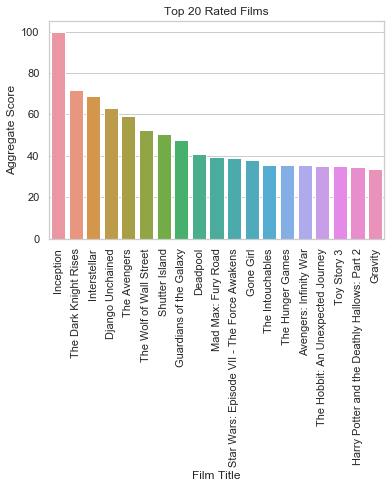

In [73]:
sns.set(style="whitegrid")
rating_title_score_barplot = sns.barplot(x='primary_title',y='aggregate_score',data=top_200_rating.head(20))
rating_title_score_barplot = rating_title_score_barplot.set(xlabel='Film Title',ylabel='Aggregate Score', title = "Top 20 Rated Films")
plt.xticks(rotation=90)


# Analysis of above graph goes here

In [74]:
print('Sample Aggregate Score mean:', round(rating.aggregate_score.mean(),2))
print('Sample Aggregate Score sd:', round(rating.aggregate_score.std(),2))
print('Top 200 Aggregate Score mean:', round(top_200_rating.aggregate_score.mean(),2))
print('Top 200 Aggregate Score sd:', round(top_200_rating.aggregate_score.std(),2))


Sample Aggregate Score mean: 5.59
Sample Aggregate Score sd: 7.59
Top 200 Aggregate Score mean: 23.25
Top 200 Aggregate Score sd: 10.98


## Of these films, which genres are most prevalent? 

In [75]:
genres_popularity = top_200_rating [['primary_title', 'popularity', 'genres','aggregate_score','total_votes']]

In [76]:
genres_popularity = genres_popularity.explode('genres')

In [77]:
genres_popularity['genres'] = genres_popularity['genres'].map(lambda x: str(x))
#Converting genres column to a string, so that I can count its frequency

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 19 Text xticklabel objects>)

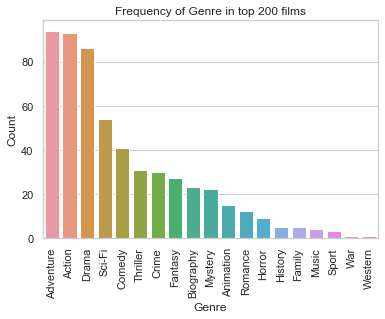

In [78]:
genre_count = sns.countplot(x='genres',data=genres_popularity,order = genres_popularity['genres'].value_counts().index)
genre_count = genre_count.set(xlabel='Genre',ylabel='Count', title = "Frequency of Genre in top 200 films")
plt.xticks(rotation=90)

# Analysis of above graph goes here

In [79]:
top_3_genres = genres_popularity[genres_popularity['genres'].isin(['Adventure','Action','Drama']) ]
#Picking films only from the top 3 genres

# What is the relationship between a film's review score and the number of reviews?

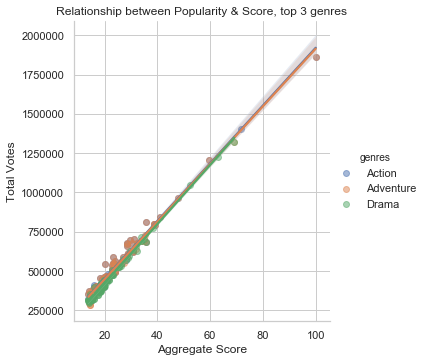

In [80]:
scatter_score_totalvotes = sns.lmplot(x='aggregate_score',y='total_votes',data=top_3_genres,hue='genres',scatter_kws={'alpha':0.5})
scatter_score_totalvotes.set(xlabel='Aggregate Score',ylabel='Total Votes', title = "Relationship between Popularity & Score, top 3 genres")



# Analysis of above graph goes here

## Analyzing the top 3 genres, what is the relationship between a films review score and its popularity?

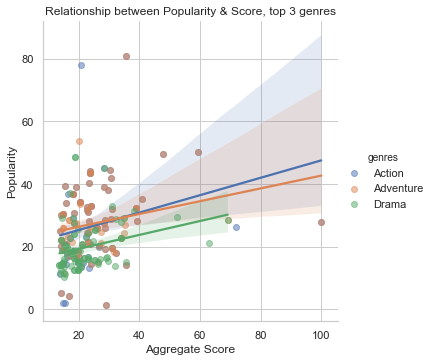

In [81]:
scatter_score_popularity = sns.lmplot(x='aggregate_score',y='popularity',data=top_3_genres,hue='genres',scatter_kws={'alpha':0.5})
scatter_score_popularity.set(xlabel='Aggregate Score',ylabel='Popularity', title = "Relationship between Popularity & Score, top 3 genres")



# Analysis of above graph goes here

In [82]:
top_200_directors = top_200_rating [['primary_title', 'popularity', 'genres','aggregate_score','total_votes','directors']]
#Creating a new table to identify best directors of top 200 films

In [83]:
top_200_directors = top_200_directors.explode('directors')
#Splitting directors into different rows

In [84]:
top_200_directors = top_200_directors.merge(imdb_crew,right_on='nconst',left_on='directors')
#Joining imdb_crew table to identify direcotrs by their ID

In [85]:
top_200_directors = top_200_directors[['primary_title','popularity','aggregate_score','total_votes','primary_name','death_year']]
#Keeping only the columns that I will need

In [86]:
top_200_directors = top_200_directors.drop(top_200_directors[top_200_directors['death_year'] != 0].index)
#Removing all deceased directors

## Which directors should we consider hiring? (That is, those who have worked on the highest number of highly rated films)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

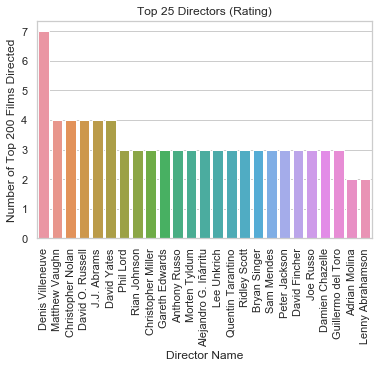

In [87]:
top_directors_rating = sns.countplot(x='primary_name',data=top_200_directors,order = top_200_directors['primary_name'].value_counts().head(25).index)
top_directors_rating = top_directors_rating.set(xlabel='Director Name',ylabel='Number of Top 200 Films Directed', title = "Top 25 Directors (Rating)")
plt.xticks(rotation=90)

# Analysis of above graph goes here

In [88]:
top_200_writers = top_200_rating [['primary_title', 'popularity', 'genres','aggregate_score','total_votes','writers']]
#Following same process for top writers

In [89]:
top_200_writers = top_200_writers.explode('writers')

In [90]:
top_200_writers = top_200_writers.merge(imdb_crew,right_on='nconst',left_on='writers')

In [91]:
top_200_writers = top_200_writers[['primary_title','popularity','aggregate_score','total_votes','primary_name','death_year']]

In [92]:
top_200_writers = top_200_writers.drop(top_200_writers[top_200_writers['death_year'] != 0].index)

## Which writers should we consider hiring? (That is, those who have worked on the highest number of highly rated films)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

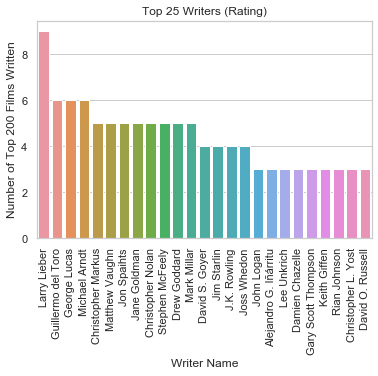

In [93]:
top_writers_rating = sns.countplot(x='primary_name',data=top_200_writers,order = top_200_writers['primary_name'].value_counts().head(25).index)
top_writers_rating = top_writers_rating.set(xlabel='Writer Name',ylabel='Number of Top 200 Films Written', title = "Top 25 Writers (Rating)")
plt.xticks(rotation=90)

# Analysis of above graph goes here

## Review Rating Findings Recap
    1. Observation 1
    2. Observation 2
    3. Observation 3

## Business Recommendations
    1. Recommendation 1
    2. Recommendation 2
    3. Recommendation 3

## Limitations
    1. Limitation 1
    2. Limitation 2
    3. Limitation 3